In [1]:
from os import chdir
chdir('..')

In [45]:
import matplotlib.pyplot as plt
import math
import seaborn as sns
import pandas as pd
import numpy as np
from polylidar import extractPlanesAndPolygons, extractPolygons
from shapely.geometry import LineString
from shapely.affinity import scale
from matplotlib.transforms import Bbox


from concave_evaluation.helpers import fake_building, plot_line, BLUE, GRAY, plot_arrow, scale_axes, plot_poly
from concave_evaluation.test_generation import random_points_within
from concave_evaluation.polylidar_evaluation import convert_to_shapely_polygons
%matplotlib notebook
sns.set()
sns.set_style("whitegrid")

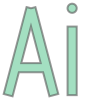

In [3]:
from shapely.geometry import box, Point, MultiPoint, asMultiPoint
from shapely.affinity import translate
def make_letter_a():
    left_leg = MultiPoint([(0,0),(5,19)]).minimum_rotated_rectangle.buffer(1, cap_style=2)
    right_leg = MultiPoint([(10,0),(5,19)]).minimum_rotated_rectangle.buffer(1, cap_style=2)
    bar = box(2, 5, 8, 7)
    poly = left_leg
    poly = poly.union(bar)
    poly = poly.union(right_leg)

    return poly
def make_letter_i(xoff=13):
    poly = box(0, 0,2, 15)
    dot = Point(1, 19).buffer(1)
    poly = poly.union(dot)
    poly = translate(poly, xoff=xoff)
    return poly
a_poly = make_letter_a()
i_poly = make_letter_i()

# Create GT polygon
poly_letter = a_poly.union(i_poly)
# Generate Random Points
letter_points = random_points_within(poly_letter, 1000)
# Extract Polylidar polgyons
polygons = extractPolygons(letter_points, alpha=0.8)
concave_polygons = convert_to_shapely_polygons(
    polygons, letter_points, return_first=False)
convex_polygon = asMultiPoint(letter_points).convex_hull
# Show ground truth polygon
poly_letter

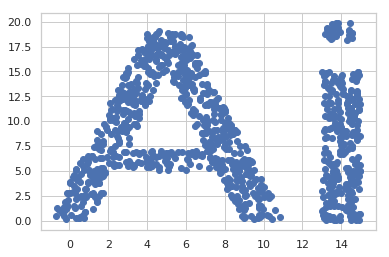

In [4]:
plt.scatter(letter_points[:, 0], letter_points[:, 1])

In [73]:
def generate_convex_concave_comparison(points, convex_poly, concave_poly):
    fig , (ax0,ax1, ax2)  = plt.subplots(nrows=1, ncols=3, figsize=(8,3))
    plot_poly(poly_letter, ax1, plot_holes=True)
    ax1.scatter(letter_points[:, 0], letter_points[:, 1], s=1)
    ax0.scatter(letter_points[:, 0], letter_points[:, 1], s=1)
    plot_poly(convex_poly, ax0, color='red')
    ax2.scatter(letter_points[:, 0], letter_points[:, 1], s=1)
    plot_poly(concave_poly, ax2,plot_holes=True)
    for ax in [ax0,ax1,ax2]:
        ax.axis('off')
    return fig, (ax0, ax1, ax2)

def full_extent(ax, pad=0.0):
    """Get the full extent of an axes, including axes labels, tick labels, and
    titles."""
    # For text objects, we need to draw the figure first, otherwise the extents
    # are undefined.
    ax.figure.canvas.draw()
    items = ax.get_xticklabels() + ax.get_yticklabels()
#    items += [ax, ax.title, ax.xaxis.label, ax.yaxis.label]
#     items += [ax, ax.title]
    items = [ax]
    bbox = Bbox.union([item.get_window_extent() for item in items])

    return bbox.expanded(1.0 + pad, 1.0 + pad)

def save_indiviudal(fig, axs, base_name='convex_vs_concave', ext='.pdf'):
    for i, ax in enumerate(axs):
        extent = full_extent(ax, pad=0).transformed(fig.dpi_scale_trans.inverted())
        name = base_name + '_' + str(i) + ext
        fig.savefig(name, bbox_inches=extent)
    

<IPython.core.display.Javascript object>


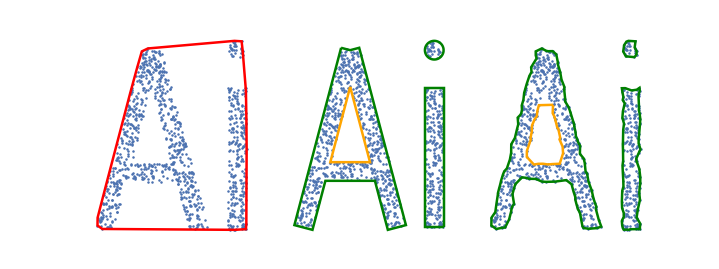

In [75]:
fig, (ax0, ax1, ax2) = generate_convex_concave_comparison(letter_points, convex_polygon, concave_polygons)
save_indiviudal(fig, (ax0, ax1, ax2), base_name="assets/pics/concave_vs_convex")